In [25]:
import utils
import os
import pandas as pd
import torch
import numpy as np
from visualize import visualize_pt_graph

In [2]:
data_root = "data/bindingnetcc"
base_graphs_path = os.path.join(data_root, "subset_20p_base_graphs/preprocessed")
rcut3_path = os.path.join(data_root, "subset_20p_no_supercell_crossconnect_rcut_3/processed/merged_lifted.pt")
no_cross_connect_path = os.path.join(data_root, "subset_20p_no_supercell_no_connect_cross_self/processed/merged_lifted.pt")

In [ ]:
rcut3_graphs = torch.load(rcut3_path, weights_only=False)

In [ ]:
print(len(rcut3_graphs))

In [ ]:
rcut3_prelift_path = os.path.join(data_root, "subset_20p_no_supercell_crossconnect_rcut_3/preprocessed/merged")

In [ ]:
rcut3_merged_count = len(os.listdir(rcut3_prelift_path))
print(rcut3_merged_count)

In [ ]:
index = pd.read_csv("/rds/general/user/kgb24/ephemeral/BindingNetv2/processed/indexes/Index_BindingNetv2_pockets_subset_20p.csv")
print(len(index))

In [ ]:
no_cross_graphs_prelift_path = os.path.join(data_root, "subset_20p_no_supercell_no_connect_cross_self/preprocessed/merged")
no_cross_merged_path = os.listdir(no_cross_graphs_prelift_path)
no_cross_merged_count = len(no_cross_merged_path)
print(no_cross_merged_count)

In [ ]:
no_cross_to_visualize = os.path.join(no_cross_graphs_prelift_path, no_cross_merged_path[0])
visualize_pt_graph(no_cross_to_visualize, "2d")

In [ ]:
rcut3_graphs_prelift_path = os.path.join(data_root, "subset_20p_no_supercell_crossconnect_rcut_3/preprocessed/merged")
rcut3_merged_path = os.listdir(rcut3_graphs_prelift_path)
rcut3_merged_count = len(rcut3_merged_path)
print(rcut3_merged_count)

In [ ]:
rcut3_to_visualize = os.path.join(rcut3_graphs_prelift_path, rcut3_merged_path[0])
visualize_pt_graph(rcut3_to_visualize, "2d")

In [3]:
no_connect_cross_lifted_path = "data/bindingnetcc/subset_20p_no_supercell_no_connect_cross_self/processed/merged_lifted.pt"
no_cross_graphs = torch.load(no_connect_cross_lifted_path, weights_only=False)

In [7]:
print("no_cross_graphs[0]")
print(no_cross_graphs[0].keys())
for key in no_cross_graphs[0]:
    print(f"key {key} has length: {len(no_cross_graphs[0][key])} and type {type(no_cross_graphs[0][key])}")

print("\nno_cross_graphs[1]")
print(no_cross_graphs[1].keys())
for key in no_cross_graphs[1]:
    print(f"key {key} has length: {len(no_cross_graphs[1][key])} and type {type(no_cross_graphs[1][key])}")

no_cross_graphs[0]
dict_keys(['pos', 'cells_0', 'slices_0', 'cells_1', 'slices_1', 'x_0', 'x_1', 'mem_0', 'mem_1', 'adj_0_0_1', 'id', 'y'])
key pos has length: 51064333 and type <class 'torch.Tensor'>
key cells_0 has length: 51064333 and type <class 'torch.Tensor'>
key slices_0 has length: 51064333 and type <class 'torch.Tensor'>
key cells_1 has length: 94548450 and type <class 'torch.Tensor'>
key slices_1 has length: 47274225 and type <class 'torch.Tensor'>
key x_0 has length: 51064333 and type <class 'torch.Tensor'>
key x_1 has length: 47274225 and type <class 'torch.Tensor'>
key mem_0 has length: 51064333 and type <class 'torch.Tensor'>
key mem_1 has length: 47274225 and type <class 'torch.Tensor'>
key adj_0_0_1 has length: 2 and type <class 'torch.Tensor'>
key id has length: 137515 and type <class 'list'>
key y has length: 137515 and type <class 'torch.Tensor'>

no_cross_graphs[1]
dict_keys(['pos', 'cells_0', 'slices_0', 'cells_1', 'slices_1', 'x_0', 'x_1', 'mem_0', 'mem_1', 'adj_0

In [9]:
def extract_sample(complex_data, sample_idx):
    """Extract a single sample from the combinatorial complex saved by InMemoryDataset"""
    
    # Check if this is the saved format (tuple with merged data and slices)
    if isinstance(complex_data, tuple) and len(complex_data) >= 2:
        # InMemoryDataset format: (merged_data, slices, class_type)
        merged_data = complex_data[0]  # The actual merged tensors
        slices = complex_data[1]       # The slice boundaries
        
        # Get slice boundaries for this sample
        start_node = slices['pos'][sample_idx]
        end_node = slices['pos'][sample_idx + 1]
        
        start_edge = slices['cells_1'][sample_idx] 
        end_edge = slices['cells_1'][sample_idx + 1]
        
        # Extract the sample's data from merged tensors
        sample_nodes = merged_data['cells_0'][start_node:end_node]
        sample_edges = merged_data['cells_1'][start_edge:end_edge]
        sample_pos = merged_data['pos'][start_node:end_node]
        sample_features = merged_data['x_0'][start_node:end_node]
        
        return {
            'nodes': sample_nodes,
            'edges': sample_edges, 
            'positions': sample_pos,
            'features': sample_features,
            'target': merged_data['y'][sample_idx],
            'id': merged_data['id'][sample_idx] if 'id' in merged_data else f'sample_{sample_idx}'
        }
    
    else:
        # Fallback for other formats
        print("Warning: Expected InMemoryDataset format (tuple with merged_data and slices)")
        return None

In [10]:
graph1 = extract_sample(no_cross_graphs, 0)

In [13]:
def visualize_sample(sample, mode="3d"):
    """
    Visualize a single sample extracted from extract_sample function
    
    Args:
        sample: Output from extract_sample function
        mode: "3d" or "2d" visualization
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    if sample is None:
        print("No sample data to visualize")
        return
    
    # Get positions
    pos = sample['positions']
    if pos.dim() == 2 and pos.size(1) >= 2:
        # Use first 2 dimensions for 2D plot
        x, y = pos[:, 0].cpu().numpy(), pos[:, 1].cpu().numpy()
        
        # Create plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.set_title(f'Sample: {sample["id"]}')
        
        # Plot nodes
        ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Nodes')
        
        # Plot edges if available
        if 'edges' in sample and sample['edges'].numel() > 0:
            edges = sample['edges'].cpu().numpy()
            # Check the shape of edges tensor
            print(f"Edges tensor shape: {edges.shape}")
            
            if edges.ndim == 2 and edges.shape[1] >= 2:
                # Edges is a 2D tensor with [num_edges, 2] shape
                for i in range(edges.shape[0]):
                    start_idx, end_idx = int(edges[i, 0]), int(edges[i, 1])
                    if start_idx < len(x) and end_idx < len(x):
                        ax.plot([x[start_idx], x[end_idx]], [y[start_idx], y[end_idx]], 
                               'gray', alpha=0.5, linewidth=1)
            else:
                print(f"Unexpected edges format: {edges.shape}")
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"Cannot visualize: positions shape is {tuple(pos.shape)}")

Edges tensor shape: (676,)
Unexpected edges format: (676,)


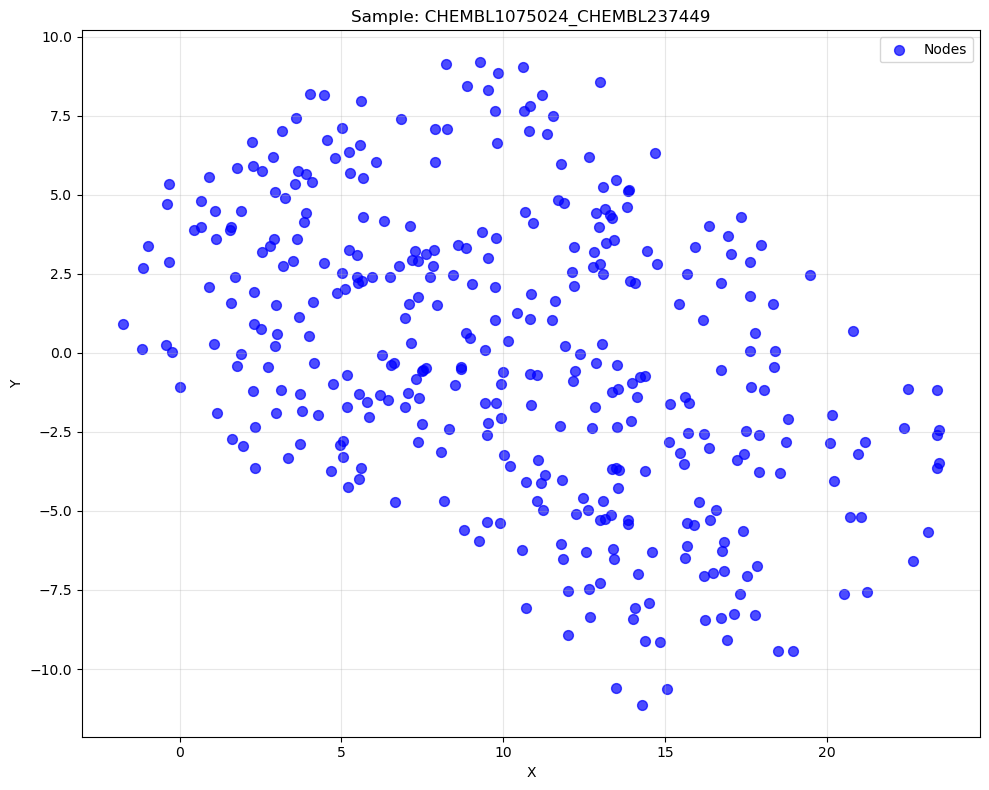

In [14]:
visualize_sample(graph1)

In [15]:
def inspect_sample(sample):
    """
    Print detailed information about a sample extracted from extract_sample function
    
    Args:
        sample: Output from extract_sample function
    """
    if sample is None:
        print("No sample data to inspect")
        return
    
    print(f"=== Sample Inspection ===")
    print(f"Sample ID: {sample['id']}")
    print(f"Target value: {sample['target']}")
    print()
    
    print("=== Tensor Shapes ===")
    for key, value in sample.items():
        if isinstance(value, torch.Tensor):
            print(f"{key:12}: {tuple(value.shape)}")
        else:
            print(f"{key:12}: {type(value)} (length: {len(value) if hasattr(value, '__len__') else 'N/A'})")
    
    print()
    print("=== What Each Tensor Represents ===")
    tensor_descriptions = {
        'nodes': '0-cells (atoms/nodes) - indices into the global cell structure',
        'edges': '1-cells (bonds/edges) - indices into the global cell structure', 
        'positions': '3D coordinates of atoms (x, y, z)',
        'features': 'Node features (atomic properties, hybridization, etc.)',
        'target': 'Binding affinity value (-logAffi)',
        'id': 'Unique identifier for this protein-ligand complex'
    }
    
    for key, description in tensor_descriptions.items():
        if key in sample:
            print(f"{key:12}: {description}")
    
    print()
    print("=== Sample Statistics ===")
    if 'positions' in sample:
        pos = sample['positions']
        print(f"Number of atoms: {pos.size(0)}")
        if pos.size(1) >= 3:
            print(f"Position dimensions: {pos.size(1)} (x, y, z coordinates)")
    
    if 'features' in sample:
        feat = sample['features']
        print(f"Feature dimensions: {feat.size(1)} (atomic properties)")
    
    if 'edges' in sample and sample['edges'].numel() > 0:
        edges = sample['edges']
        print(f"Number of edges: {edges.size(0)}")
        if edges.ndim == 2:
            print(f"Edge format: [num_edges, {edges.size(1)}]")

In [16]:
inspect_sample(graph1)

=== Sample Inspection ===
Sample ID: CHEMBL1075024_CHEMBL237449
Target value: 5.46999979019165

=== Tensor Shapes ===
nodes       : (366,)
edges       : (676,)
positions   : (366, 3)
features    : (366, 14)
target      : ()
id          : <class 'str'> (length: 26)

=== What Each Tensor Represents ===
nodes       : 0-cells (atoms/nodes) - indices into the global cell structure
edges       : 1-cells (bonds/edges) - indices into the global cell structure
positions   : 3D coordinates of atoms (x, y, z)
features    : Node features (atomic properties, hybridization, etc.)
target      : Binding affinity value (-logAffi)
id          : Unique identifier for this protein-ligand complex

=== Sample Statistics ===
Number of atoms: 366
Position dimensions: 3 (x, y, z coordinates)
Feature dimensions: 14 (atomic properties)
Number of edges: 676


In [20]:
index = pd.read_csv("/rds/general/user/kgb24/ephemeral/BindingNetv2/processed/indexes/Index_BindingNetv2_pockets_subset_20p.csv")
print(len(index))

137525


In [22]:
debug_set = index.tail(200)
print(len(debug_set))

200


In [23]:
output_path = "/rds/general/user/kgb24/ephemeral/BindingNetv2/processed/indexes/debug_BindingNetv2_pockets_subset_20p.csv"
debug_set.to_csv(output_path, index=False)

In [30]:
train_ind = np.load("/rds/general/user/kgb24/ephemeral/BindingNetv2/processed/splits/subset_20p/train_indices.npy")
val_ind = np.load("/rds/general/user/kgb24/ephemeral/BindingNetv2/processed/splits/subset_20p/val_indices.npy")
test_ind = np.load("/rds/general/user/kgb24/ephemeral/BindingNetv2/processed/splits/subset_20p/test_indices.npy")
print("Train:", train_ind.shape, train_ind[:5], "...", train_ind[-5:])
print("Val:", val_ind.shape, val_ind[:5], "...", val_ind[-5:])
print("Test:", test_ind.shape, test_ind[:5], "...", test_ind[-5:])

Train: (95772,) [3 1 2 8 5] ... [137518 137505 137524 137519 137506]
Val: (20883,) [ 4 10 20 24 29] ... [137498 137503 137511 137507 137515]
Test: (20856,) [ 0  6 14 21 26] ... [137499 137495 137523 137517 137522]


In [31]:
# Create an array of indices
n_samples = len(debug_set)
indices = np.arange(n_samples)

# Compute split sizes
n_train = int(0.7 * n_samples)   # 70%
n_val   = int(0.15 * n_samples)  # 15%
# The rest goes to test
n_test  = n_samples - n_train - n_val

# Slice into splits
train_index = indices[:n_train]
val_index   = indices[n_train:n_train+n_val]
test_index  = indices[n_train+n_val:]

print("Train:", train_index.shape, train_index[:5], "...", train_index[-5:])
print("Val:", val_index.shape, val_index[:5], "...", val_index[-5:])
print("Test:", test_index.shape, test_index[:5], "...", test_index[-5:])

Train: (140,) [0 1 2 3 4] ... [135 136 137 138 139]
Val: (30,) [140 141 142 143 144] ... [165 166 167 168 169]
Test: (30,) [170 171 172 173 174] ... [195 196 197 198 199]


In [32]:
index_output_path = "/rds/general/user/kgb24/ephemeral/BindingNetv2/processed/splits/debug/"
np.save(index_output_path + 'train_indices.npy', train_index)
np.save(index_output_path + 'val_indices.npy', train_index)
np.save(index_output_path + 'test_indices.npy', train_index)